# Debugging 1D solver failures

This notebook shows an example where the 1D solver fails, and demonstrates the use of callbacks to diagnose the failure modes.
This example is adapted from the bug report at https://github.com/Cantera/cantera/issues/384.

In [1]:
import cantera as ct
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

print(f"Running Cantera version {ct.__version__}")

Running Cantera version 2.4.0


### parameter values

In [2]:
p = 50 * ct.one_atm  # pressure
tburner = 300.0  # burner temperature
mdot = 0.22  # kg/m^2/s
width = 0.05  # m

### Set up the problem

In [3]:
gas = ct.Solution('h2o2.cti')

# set state to that of the unburned gas at the burner
gas.set_equivalence_ratio(0.4, 'H2', 'O2:1.0, AR:4')
gas.TP = tburner, p

sim = ct.BurnerFlame(gas=gas, width=width)
sim.burner.mdot = mdot
sim.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0)

### Try to solve it...

In [4]:
sim.solve(loglevel=1, auto=False)


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     6.007e-06      3.742
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002309      3.011
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 
    to resolve AR H2 H2O H2O2 HO2 O O2 OH T u 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.594e-05      3.711
Attempt Newton solution of steady-state problem...    succes

Take 10 timesteps       0.02247      2.965
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.03792      2.764
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04799      2.789
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04555      2.765
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01441      2.553
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.03648      2.753
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.03463      2.334
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04383      2.197
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01387      2.045
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.02633      

CanteraError: 
***********************************************************************
CanteraError thrown by OneDim::timeStep:
Took maximum number of timesteps allowed (500) without reaching steady-state solution.
***********************************************************************


### That didn't work...what went wrong?
* We can see that the solver failed because it was taking too many timesteps without those timesteps increasing in size, as would normally be expected.
* Add a callback function to collect data after each timestep
* We are only interested in the timesteps leading up to the final, failed solution attempt, but we don't know when that will occur.
* Use the `time_step` callback to collect data after each timestep, no matter what.
* Use the `steady` callback to clear data after a successful solve 

In [5]:
# variables used to capture data within the callback functions
grid = []
TT = []
YY = []
UU = []

# Callback function must take one argument, even if we don't use it
def time_step_callback(_):
    grid[:] = sim.grid
    TT.append(sim.T)
    YY.append(sim.Y[gas.species_index('O2')])
    UU.append(sim.u)
    return 0  # Callback function must return a number

def steady_callback(_):
    TT.clear()
    YY.clear()
    UU.clear()
    return 0

# Recreate the flame object and attach the callback functions
gas.set_equivalence_ratio(0.4, 'H2', 'O2:1.0, AR:4')
gas.TP = tburner, p
sim = ct.BurnerFlame(gas=gas, width=width)
sim.burner.mdot = mdot
sim.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0)

sim.set_time_step_callback(time_step_callback)
sim.set_steady_callback(steady_callback)

### Attempt to solve the flame again
Wrap the call to `solve` in a `try`/`except` block, since we are expecting it to fail

In [6]:
try:
    sim.solve(loglevel=0, auto=False)
except ct.CanteraError as e:
    print(e)
    sim.show_stats()


***********************************************************************
CanteraError thrown by OneDim::timeStep:
Took maximum number of timesteps allowed (500) without reaching steady-state solution.
***********************************************************************


Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
    9          20        304    0.0055         14    0.0089
   12          10        299    0.0068          9    0.0096
   17          10        267    0.0087          7    0.0106
   23          20        466    0.0198         13    0.0261
   29         330      13157    0.7048        426    1.1215
   33          20        436    0.0276         16    0.0500
   38         500      19320    1.3206        673    2.2968


## Convert saved data to 2D arrays

In [7]:
T = np.array(TT)
Y = np.array(YY)
U = np.array(UU)

## Plot profiles


<IPython.core.display.Javascript object>


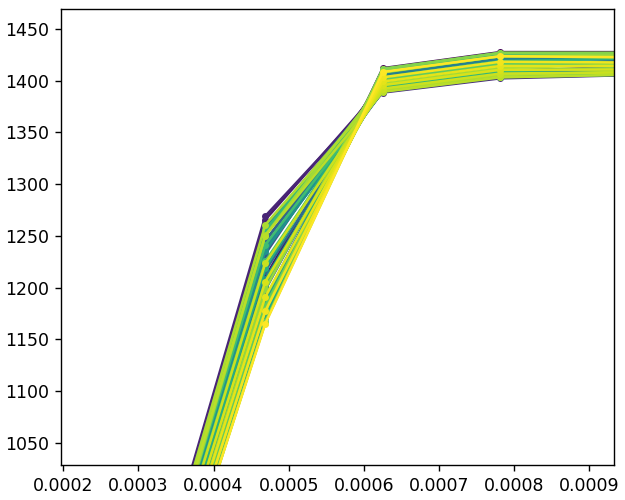

In [8]:
f,ax = plt.subplots(1, 1, figsize=(5,4))
# Plot the last N profiles
N = 50  
# Use a sequential color map so we can tell which lines belong to which timestep
C = plt.cm.viridis(np.linspace(0, 1, N))
for i in range(N):
    ax.plot(grid, T[len(T)-N+i], '.-', color=C[i])
ax.set_xlim(0, 0.002);

### Let's look at what's happening as a function of time

<IPython.core.display.Javascript object>


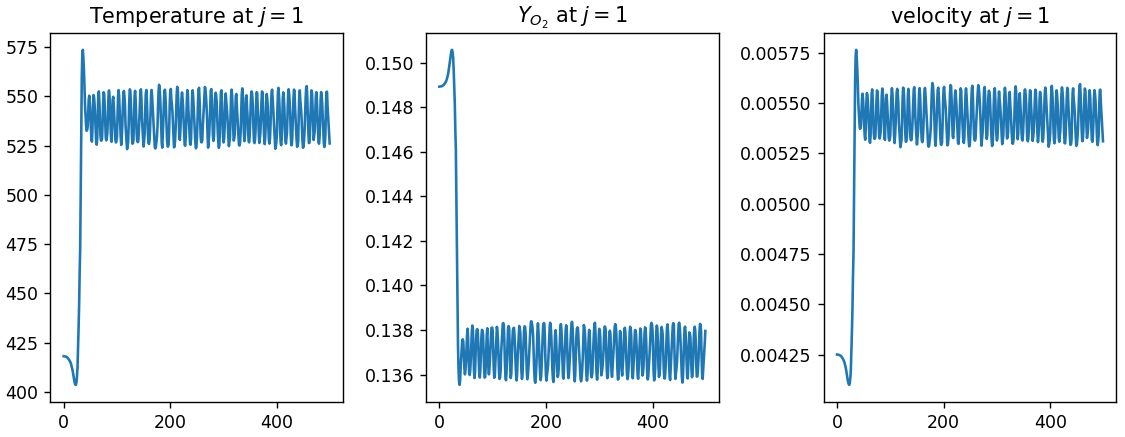

In [9]:
f,ax = plt.subplots(1, 3, figsize=(9, 3.5))
ax[0].plot(T[:,1])
ax[1].plot(Y[:,1])
ax[2].plot(U[:,1])
ax[0].set_title('Temperature at $j=1$')
ax[1].set_title('$Y_{O_2}$ at $j=1$')
ax[2].set_title('velocity at $j=1$');